In [122]:
!ls

NY_neighborhoods.geojson.txt taxi-zone-lookup.csv
Uber_EDA_ARIMA.ipynb         uber-raw-data-janjune-15.csv
aws_backup                   uber_rides.csv


In [1]:
import numpy as np
import pandas as pd
import pyflux as pf
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
uber = pd.read_csv("uber-raw-data-janjune-15.csv")

In [3]:
loc_ids = pd.read_csv("taxi-zone-lookup.csv")

In [4]:
loc_ids.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [5]:
#uber.drop(["Dispatching_base_num","Affiliated_base_num"],1).to_csv("uber_rides.csv",index_label="index")

In [6]:
uber = pd.read_csv("uber_rides.csv",index_col="index")
uber = uber.rename(columns={"locationID": "LocationID"})

In [7]:
merged = uber.merge(loc_ids,on="LocationID",how="left")

In [8]:
merged.Pickup_date = pd.to_datetime(merged.Pickup_date)
ts_agg = merged.groupby(["Pickup_date"]).agg(["count"])

In [9]:
#ts_agg.head()
hourly_agg = ts_agg.resample("1H").sum()
hourly_agg.columns = hourly_agg.columns.droplevel(level=1)

In [10]:
hourly_agg.head()

,LocationID,Borough,Zone
Pickup_date,,,
2015-01-01 00:00:00,6465,6465,6465
2015-01-01 01:00:00,6001,6001,6001
2015-01-01 02:00:00,7171,7171,7171
2015-01-01 03:00:00,5874,5874,5874
2015-01-01 04:00:00,3529,3529,3529


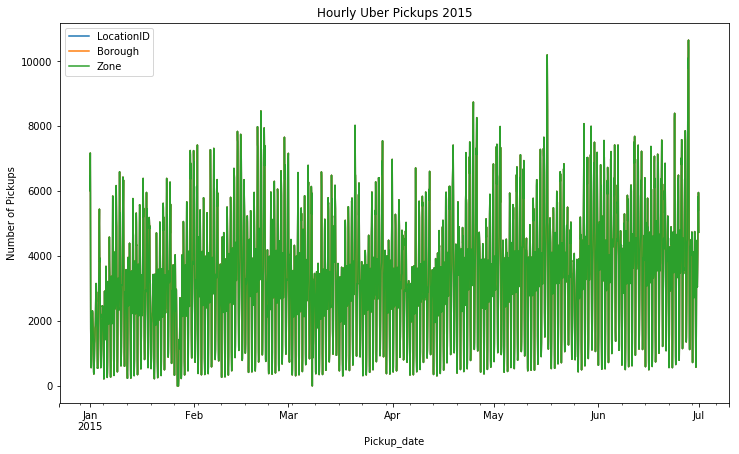

In [10]:
hourly_agg.plot(figsize=(12,7), 
          title='Hourly Uber Pickups 2015')
plt.ylabel('Number of Pickups');

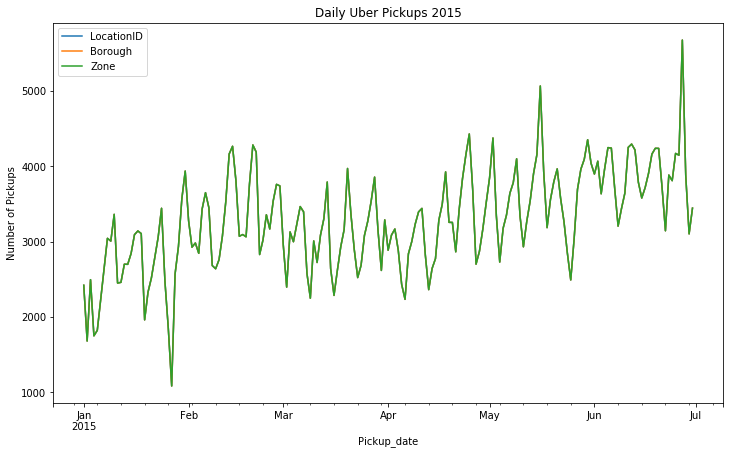

In [11]:
daily = hourly_agg.resample('24H').mean()
#daily.columns = daily.columns.droplevel(level=1)
daily.plot(figsize=(12,7), 
          title='Daily Uber Pickups 2015')
plt.ylabel('Number of Pickups');

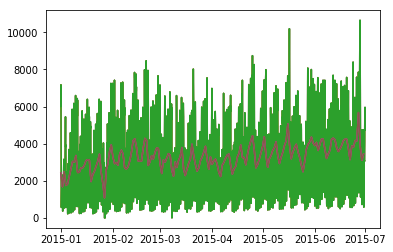

In [12]:
# plot both on same figure
plt.plot(hourly_agg)
plt.plot(daily);

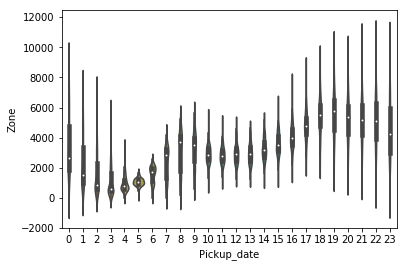

In [13]:
sns.violinplot(x=hourly_agg.index.hour, y=hourly_agg.Zone);

In [14]:
hourly_agg.head()

,LocationID,Borough,Zone
Pickup_date,,,
2015-01-01 00:00:00,6465,6465,6465
2015-01-01 01:00:00,6001,6001,6001
2015-01-01 02:00:00,7171,7171,7171
2015-01-01 03:00:00,5874,5874,5874
2015-01-01 04:00:00,3529,3529,3529


In [15]:
print(hourly_agg.Zone.std())
print(hourly_agg.Zone.diff().std())
print(hourly_agg.Zone.diff().diff().std())
print(hourly_agg.Zone.diff().diff().diff().std())

1821.7007362163995
702.7777415714612
582.3382308350128
806.7009533008892


In [16]:
# define Dickey-Fuller Test (DFT) function
import statsmodels.tsa.stattools as ts
def dftest(timeseries):
    dftest = ts.adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)

Test Statistic         -6.462490e+00
p-value                 1.431760e-08
Lags Used               3.100000e+01
Observations Used       4.312000e+03
Critical Value (1%)    -3.431867e+00
Critical Value (5%)    -2.862211e+00
Critical Value (10%)   -2.567127e+00
dtype: float64


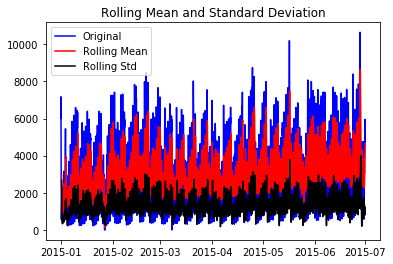

In [17]:
# run DFT on monthly
dftest(hourly_agg.Zone)

Test Statistic           -1.310711
p-value                   0.624258
Lags Used                14.000000
Observations Used       166.000000
Critical Value (1%)      -3.470370
Critical Value (5%)      -2.879114
Critical Value (10%)     -2.576139
dtype: float64


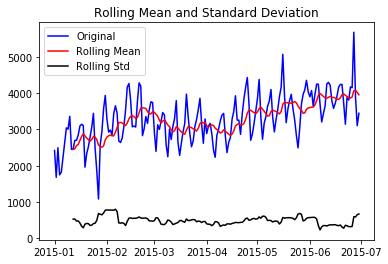

In [18]:
dftest(daily.Zone)

In [19]:
hourly_agg = hourly_agg.drop(["LocationID","Borough"],1)

In [20]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (3, 1)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (1, 0))
    pacf = plt.subplot2grid(layout, (2, 0))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

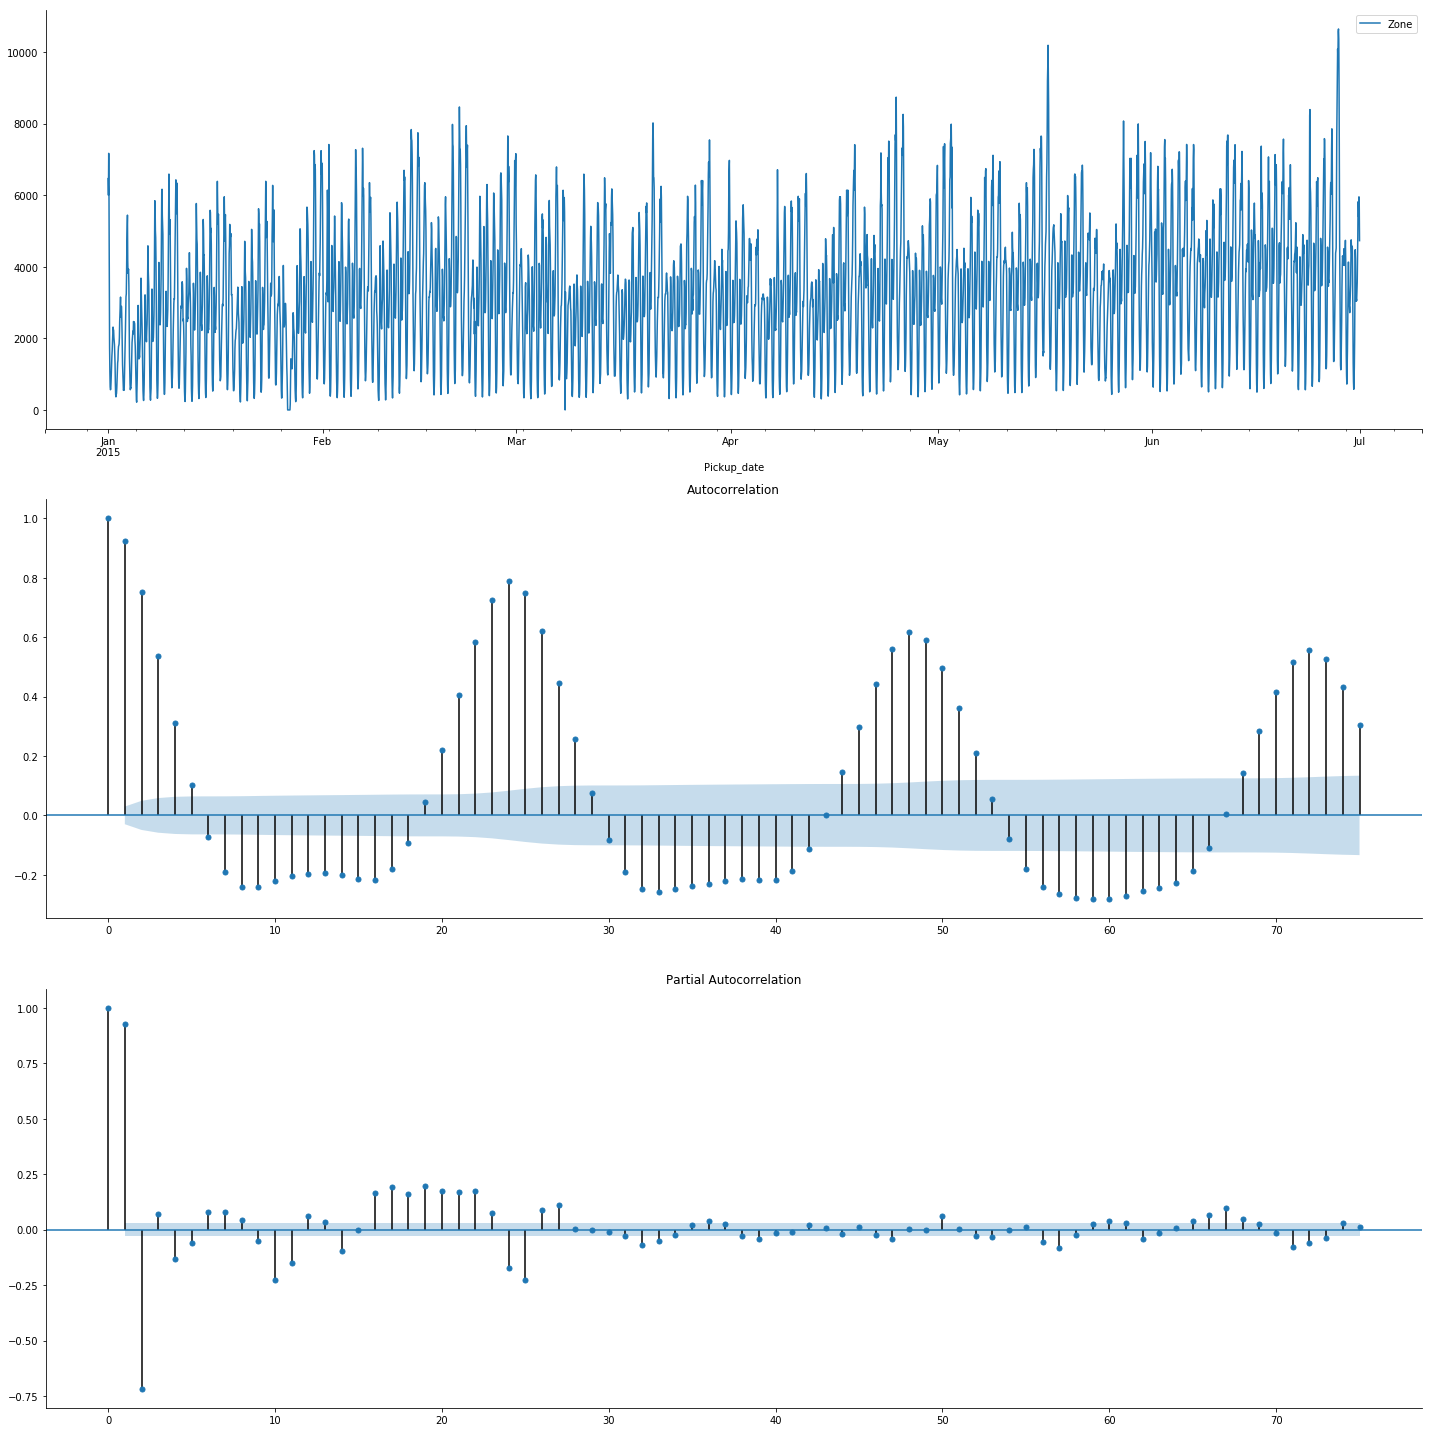

In [21]:
# helper plot for monthly temps
plt.rcParams['figure.figsize'] = [20, 20]
plots(hourly_agg, lags=75);

In [22]:
# we might need to install dev version for statespace functionality
#!pip install git+https://github.com/statsmodels/statsmodels.git
import statsmodels.api as sm

# fit SARIMA monthly based on helper plots
sar = sm.tsa.statespace.SARIMAX(hourly_agg.Zone, order=(0,0,0), seasonal_order=(2,1,1,24), trend='c').fit()
sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            Statespace Model Results                            
================================================================================
Dep. Variable:                     Zone   No. Observations:                 4344
Model:             SARIMAX(2, 1, 1, 24)   Log Likelihood              -35693.083
Date:                  Sun, 24 Jun 2018   AIC                          71396.167
Time:                          12:59:30   BIC                          71428.049
Sample:                      01-01-2015   HQIC                         71407.421
                           - 06-30-2015                                         
Covariance Type:                    opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.8508      0.746      9.183      0.000       5.389       8.313
ar.S.L24       0.5062      0.012     44.007      0.000       0.484       0.529
ar.S.L48      -0.3357      0.014    -23.846      0.000      -0.363      -0.308
ma.S.L24      -0.9647      0.005   -196.961      0.000      -0.974      -0.955
sigma2      8.636e+05   1.36e+04     63.287      0.000    8.37e+05     8.9e+05
===================================================================================
Ljung-Box (Q):                     8525.47   Jarque-Bera (JB):               844.51
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.06
Prob(H) (two-sided):                  0.13   Kurtosis:                         5.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# By Location

In [129]:
loc_agg = merged.groupby(["Pickup_date","LocationID"]).agg("count")
loc_agg.head()
# hourly_loc = loc_agg.resample("1H").sum()
# hourly_loc.columns = hourly_agg.columns.droplevel(level=1)

Borough  Zone
Pickup_date         LocationID               
2015-01-01 00:00:05 144               1     1
                    255               1     1
2015-01-01 00:00:08 113               1     1
2015-01-01 00:00:11 234               1     1
2015-01-01 00:00:13 232               1     1

In [135]:
merged.head()

,Pickup_date,LocationID,Borough,Zone
0,2015-05-17 09:47:00,141,Manhattan,Lenox Hill West
1,2015-05-17 09:47:00,65,Brooklyn,Downtown Brooklyn/MetroTech
2,2015-05-17 09:47:00,100,Manhattan,Garment District
3,2015-05-17 09:47:00,80,Brooklyn,East Williamsburg
4,2015-05-17 09:47:00,90,Manhattan,Flatiron


In [ ]:
test = merged.pivot_table(index='Pickup_date', columns='Zone', aggfunc=len, fill_value=0)
test

# Weekly

In [11]:
import numpy as np
import pandas as pd
import pyflux as pf
import warnings
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
%config InlineBackend.figure_format = 'png'
mpl.rcParams['figure.dpi']= 500

In [12]:
rides = pd.read_csv("uber_rides.csv",index_col=0)

In [13]:
rides.Pickup_date = pd.to_datetime(rides.Pickup_date)
rides = rides.assign(Pickup_date=rides.Pickup_date.dt.round('H'))
rides.set_index("Pickup_date",inplace=True)

In [14]:
hourly_rides = rides.groupby([rides.index]).count()

In [15]:
daily_mean = hourly_rides.groupby([hourly_rides.index.weekday,hourly_rides.index.hour]).mean()

In [16]:
daily_mean.head()

locationID
Pickup_date Pickup_date             
0           0            2469.115385
            1            1439.730769
            2             836.961538
            3             516.692308
            4             568.307692

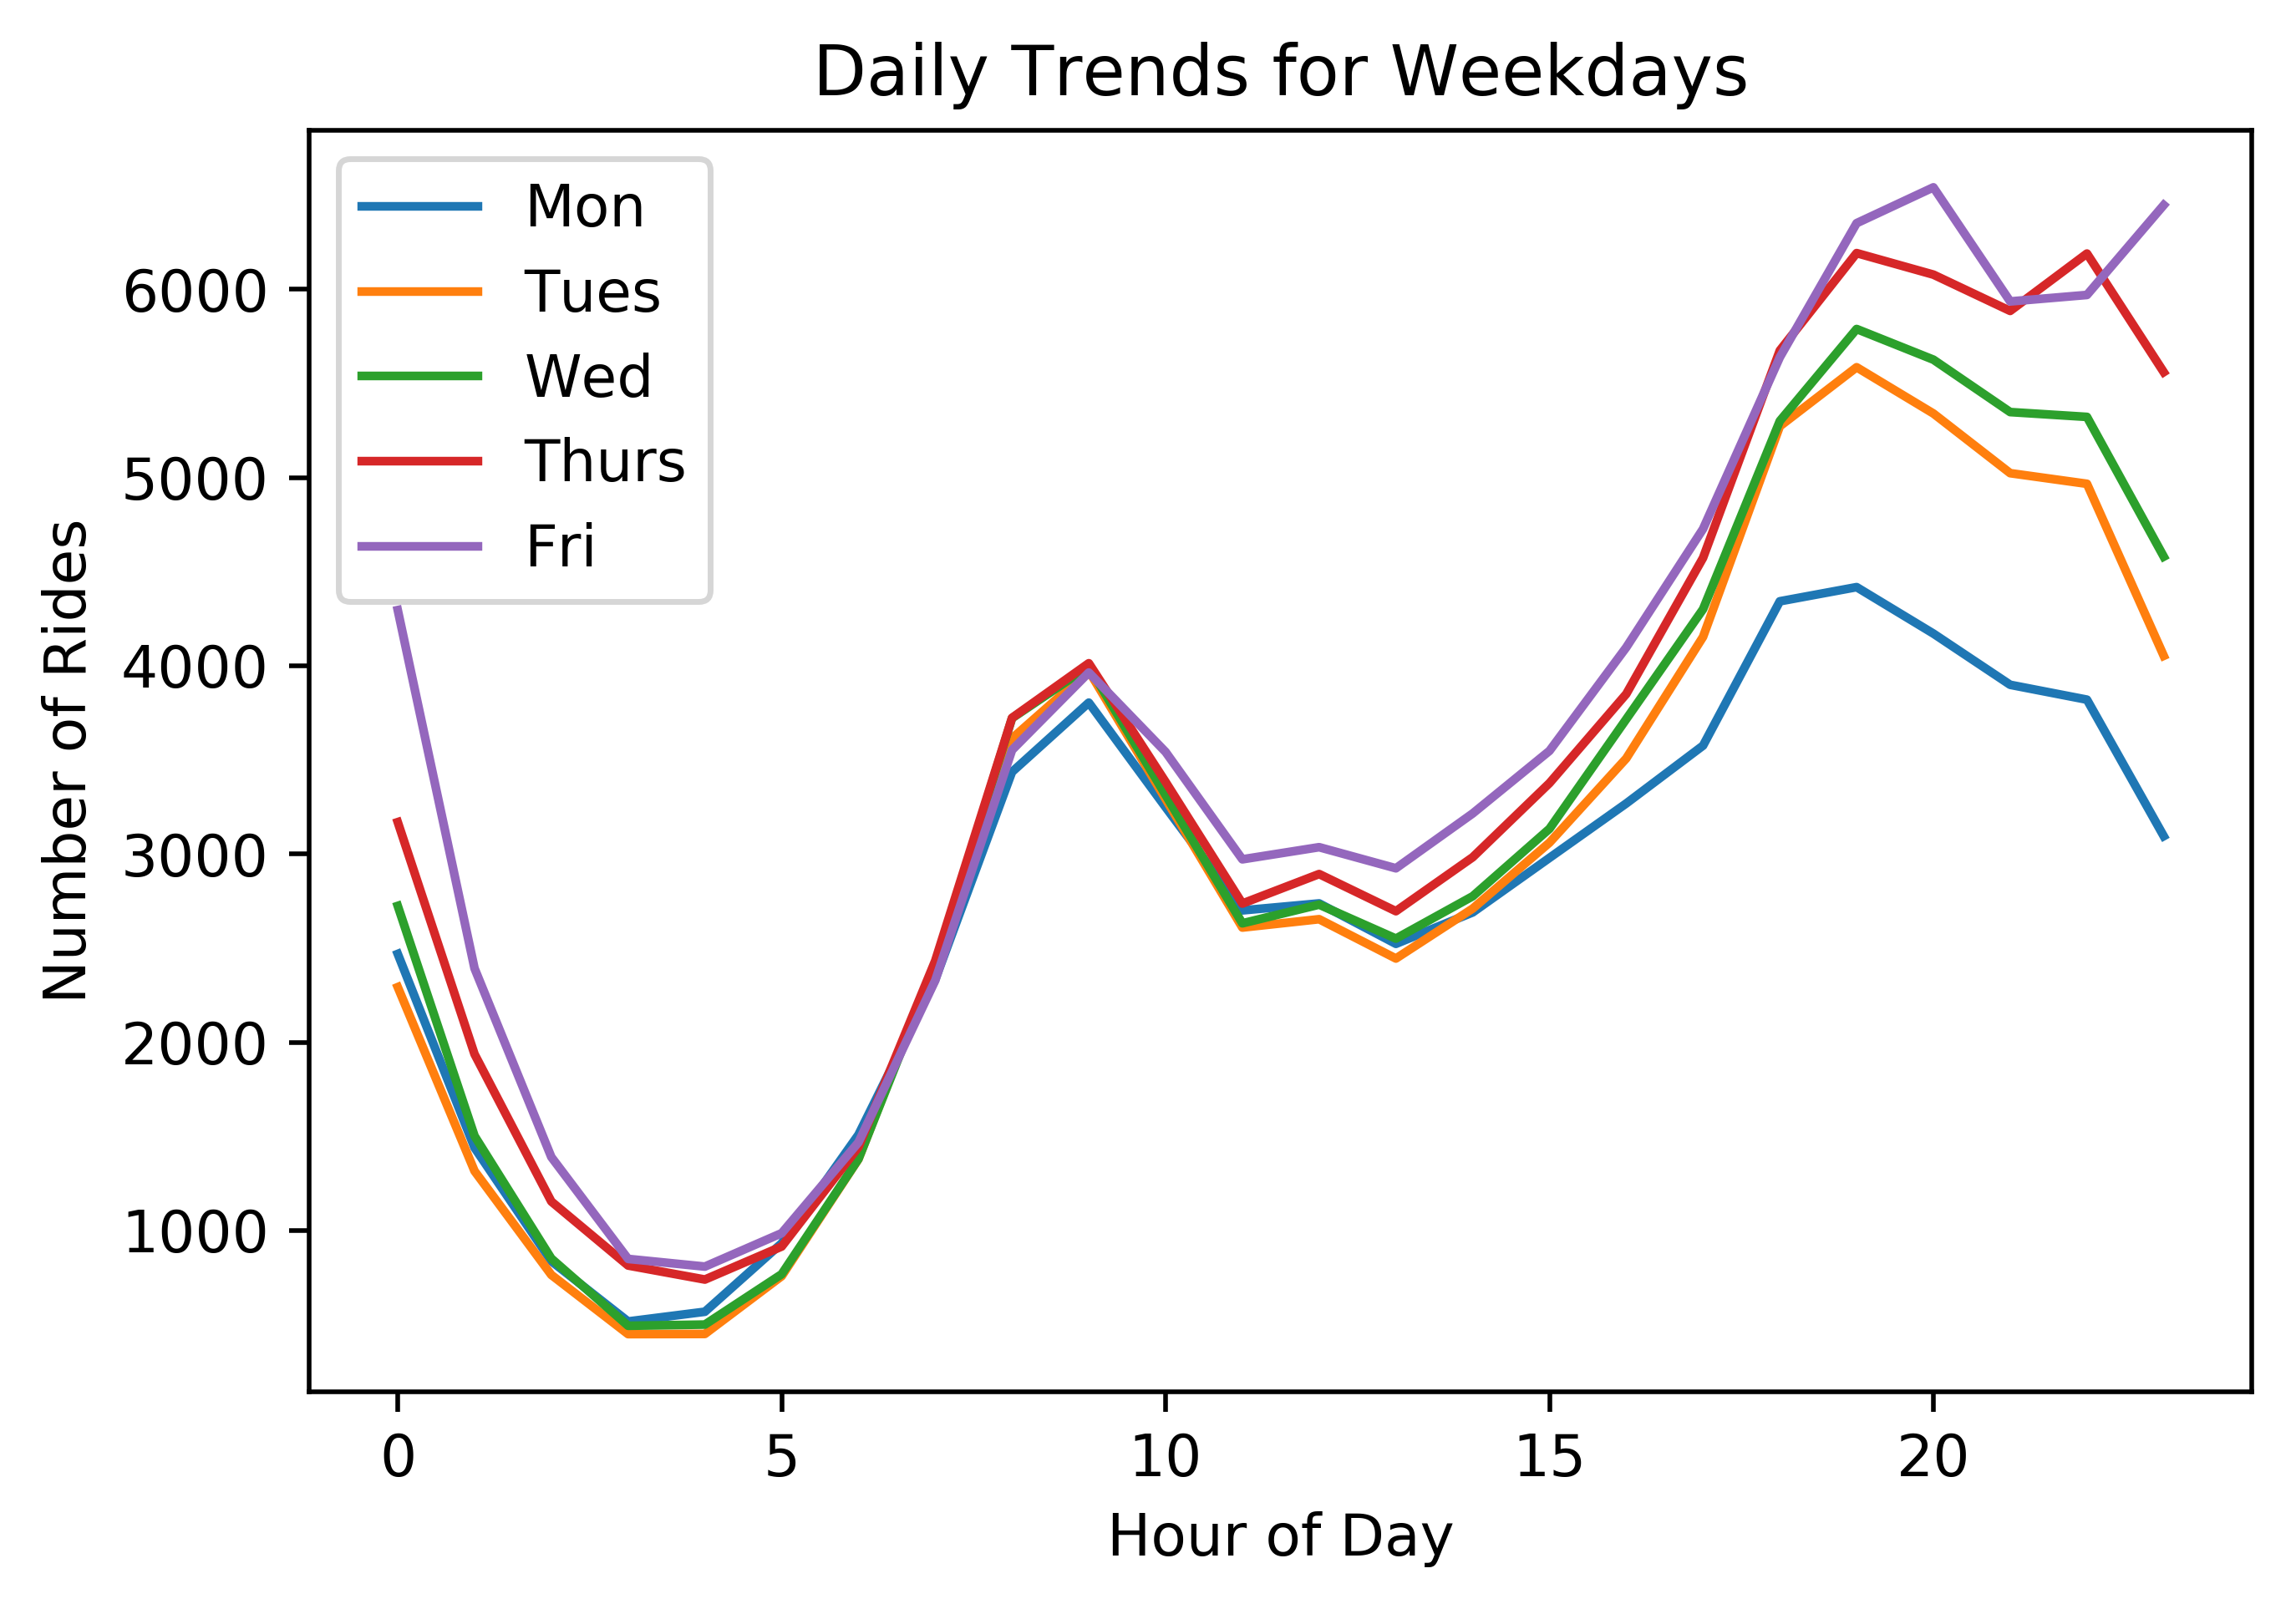

In [35]:
days = ["Mon","Tues","Wed","Thurs","Fri","Sat","Sun"]
for i, n in enumerate(days):
    x_temp = daily_mean.loc[i].index
    y_temp = daily_mean.loc[i]
    if i > 4:
        pass
        #plt.plot(x_temp, y_temp, '--', lw=4, label=n)
    else:
        pass
        plt.plot(x_temp,y_temp,label=n)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.title("Daily Trends for Weekdays")
plt.legend();

In [118]:
import random
a = range(24*7)
b = range(5,24*7+5)


In [119]:
c = pd.DataFrame({"aaa":a,"bbb":b})

In [120]:
rides.tail()

,locationID
Pickup_date,
2015-05-08 16:00:00,186
2015-05-08 16:00:00,263
2015-05-08 16:00:00,90
2015-05-08 16:00:00,45
2015-05-08 16:00:00,144


([<matplotlib.axis.XTick at 0x1a0d38aa90>,
 <a list of 7 Text xticklabel objects>)

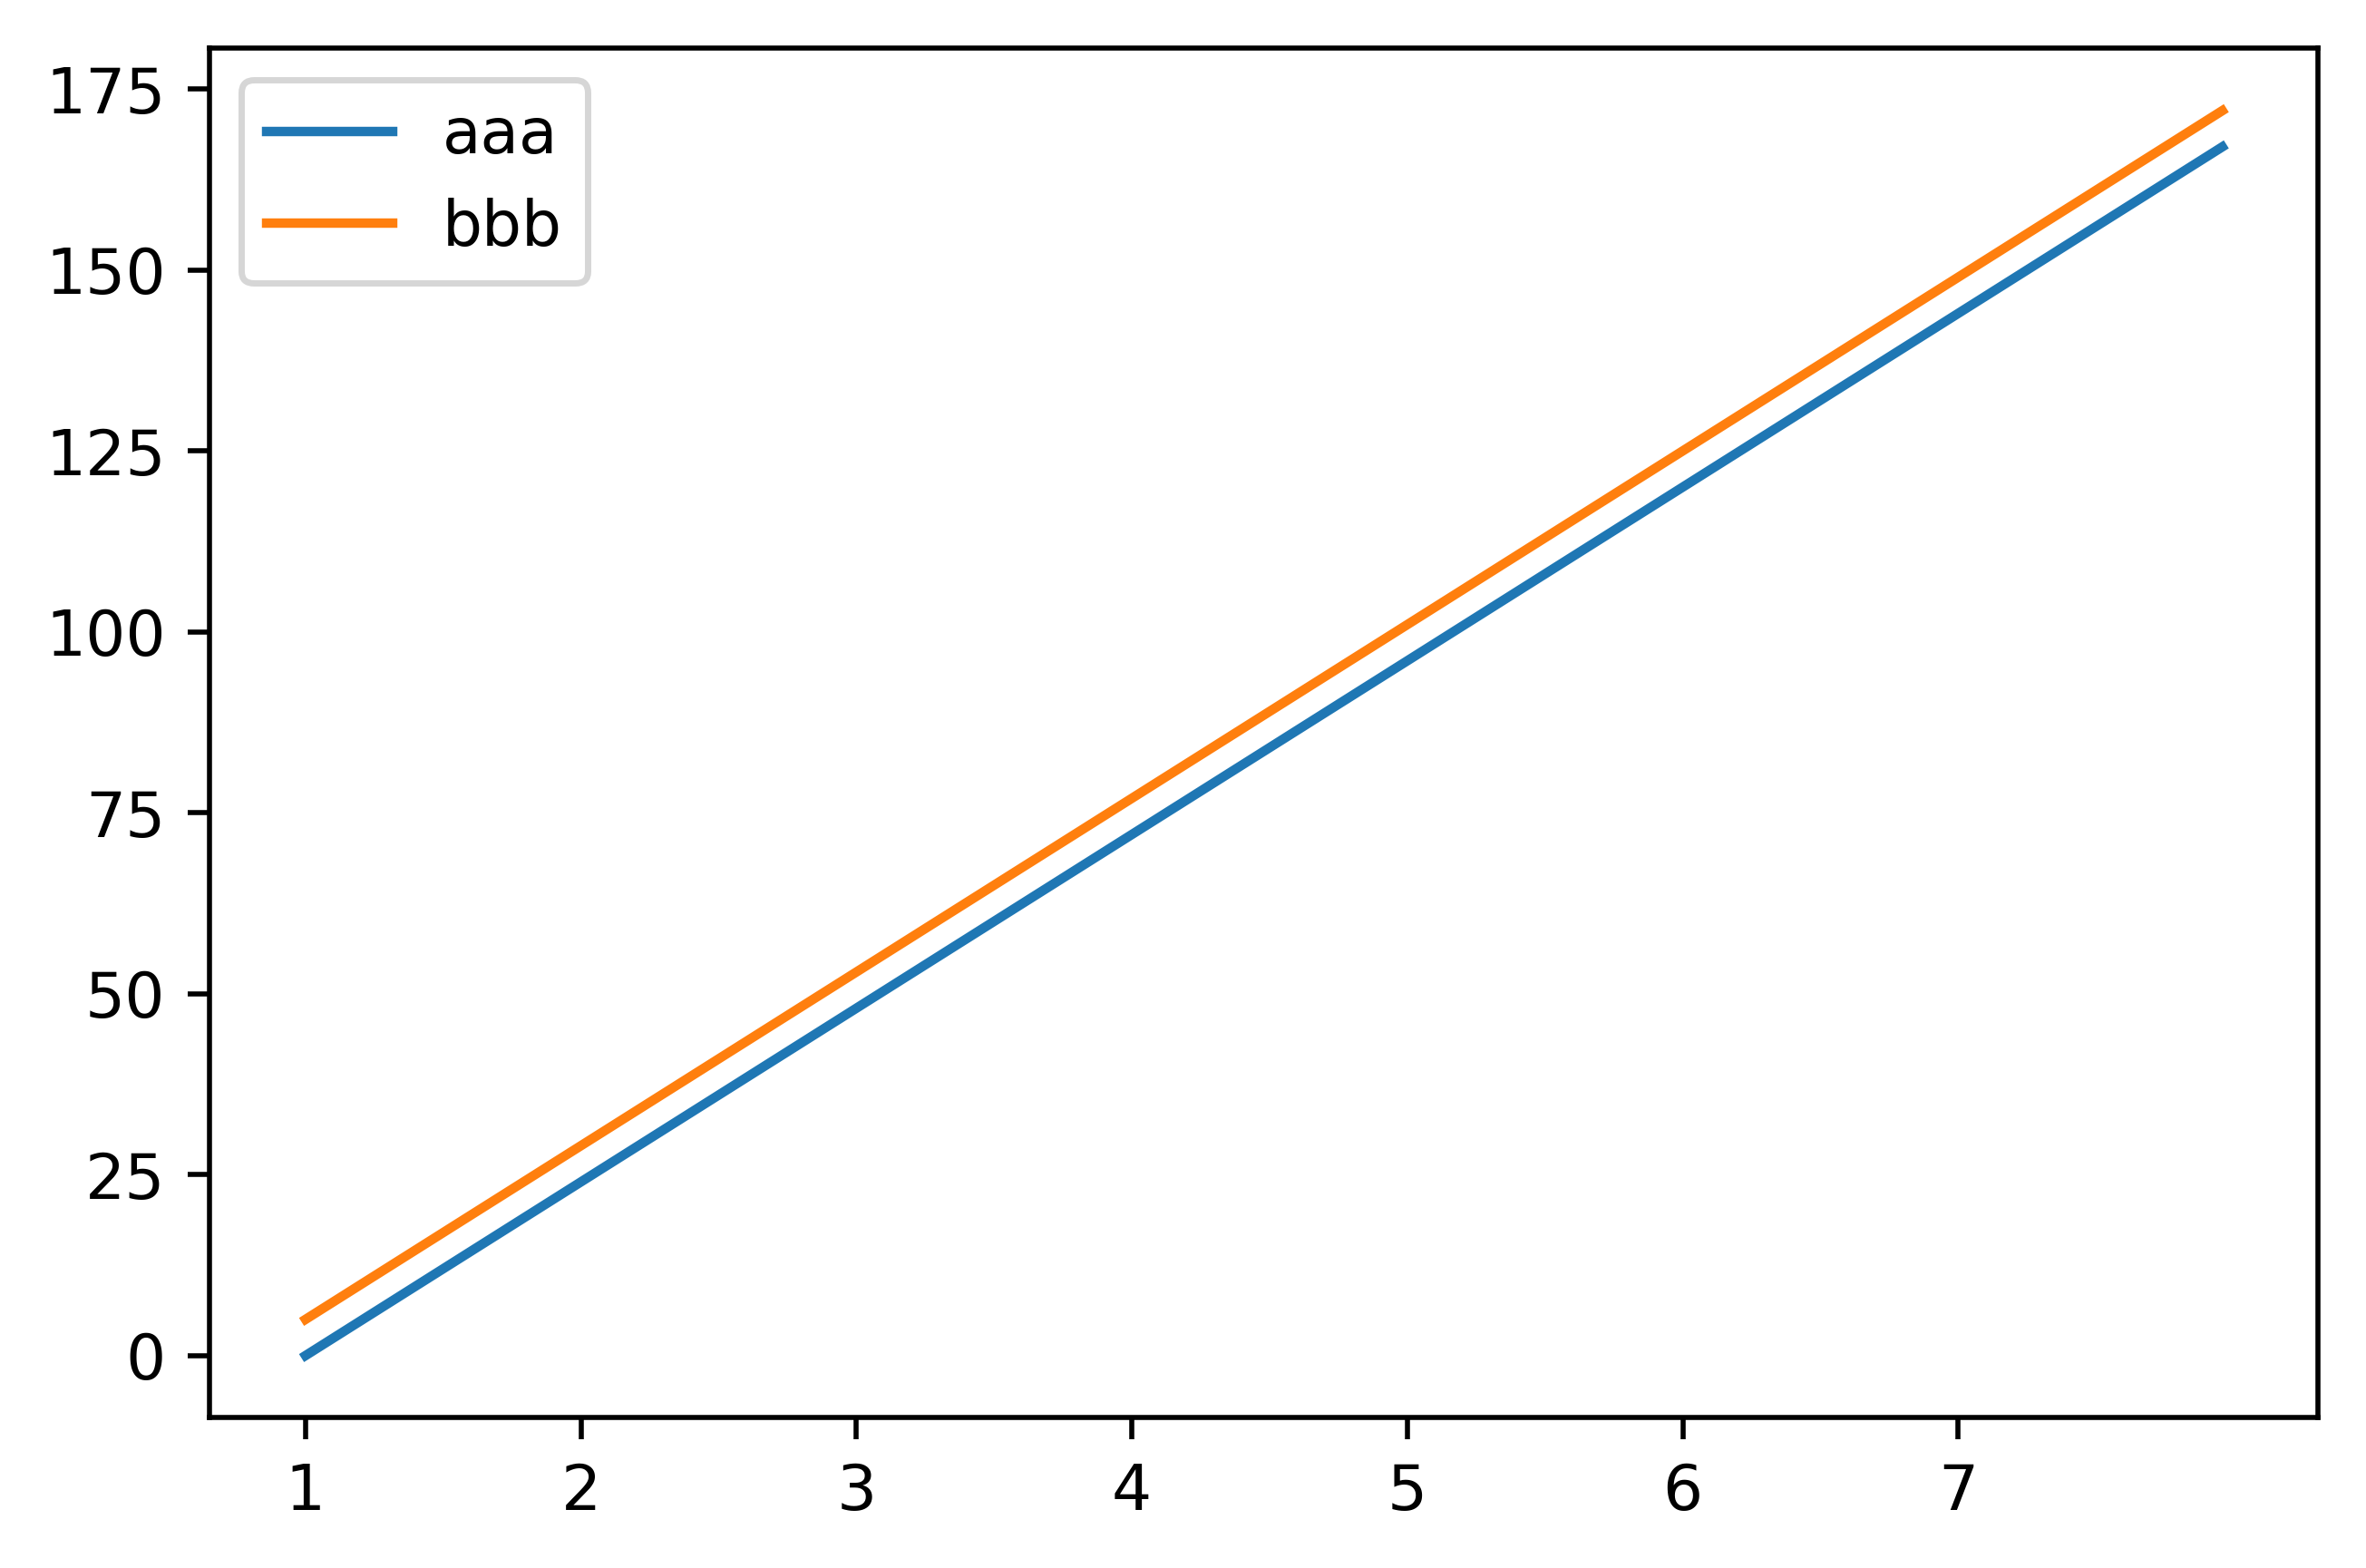

In [121]:
c.plot(x=c.index);
plt.xticks(range(0,24*7,24),range(1,8))
#plt.set_xticklabels([2,3,4])

In [38]:
prediction = pd.read_pickle("prediction_df.pkl")
prediction.to_csv("prediction_df.csv")

In [59]:
prediction

,Alphabet City,Astoria,Battery Park City,Bay Ridge,Bayside,Bedford,Belmont,Bensonhurst West,Bloomingdale,Boerum Hill,...,West Concourse,West Village,Williamsburg (North Side),Williamsburg (South Side),Windsor Terrace,Woodhaven,Woodside,World Trade Center,Yorkville East,Yorkville West
date,,,,,,,,,,,,,,,,,,,,,
2015-06-24 00:00:00,40.658741,45.473736,72.536194,17.356869,7.158208,38.310669,13.841780,6.091621,12.547997,33.513988,...,24.306940,203.402939,143.193192,76.970100,14.634380,7.384604,18.589754,30.398211,56.987297,66.515854
2015-06-24 01:00:00,33.419827,39.123207,57.266296,15.062588,5.697656,33.489635,9.844825,4.790140,10.139574,28.734953,...,16.990671,160.810013,120.037163,66.970612,11.265885,5.973586,13.622052,25.679674,38.874916,50.690910
2015-06-24 02:00:00,24.484945,29.282124,38.815353,11.690464,4.102130,25.774446,6.377238,3.386659,6.794509,20.611616,...,9.240165,111.828423,92.918915,51.735592,7.700085,4.305884,9.271729,19.656420,21.289513,31.505798
2015-06-24 03:00:00,16.006037,20.653666,23.420321,7.999084,2.891170,18.163879,3.800623,2.394604,4.383029,13.456511,...,4.644794,64.626144,65.544235,35.538212,4.995521,3.146536,6.561584,13.071737,12.185156,18.851051
2015-06-24 04:00:00,10.684501,15.349733,15.893059,5.546409,2.059160,12.194077,2.343338,1.742186,3.091767,9.001820,...,2.504396,36.993633,43.135551,23.192236,3.496721,2.368123,5.138108,9.191843,8.887182,13.357550
2015-06-24 05:00:00,8.731873,13.664402,13.446381,4.796280,1.618970,9.631017,1.630051,1.456449,2.644769,7.776489,...,1.735434,26.235617,32.204445,17.715075,3.114860,2.083773,4.523542,7.280425,8.960152,12.892943
2015-06-24 06:00:00,9.988870,15.152036,14.791665,6.233416,1.643737,10.074747,1.407574,1.742385,3.107323,9.134852,...,1.716527,27.471575,31.503246,17.994410,4.028143,2.541937,4.636880,7.709849,13.415097,18.428726
2015-06-24 07:00:00,14.474637,19.519854,19.341269,10.132274,2.021030,13.178227,1.484964,2.610046,4.640008,12.898961,...,2.191292,41.228771,37.233421,21.983870,5.977985,3.880440,5.478986,9.682803,27.743698,33.623478
2015-06-24 08:00:00,22.052773,23.638992,27.973906,13.213811,2.687792,19.092257,1.843464,3.984421,7.761087,20.194542,...,2.676230,61.452583,52.062099,28.923664,8.285690,5.500018,7.352969,12.054776,58.850311,60.874523


In [71]:
tableau_df = pd.DataFrame(columns=['Datetime', 'Zone', 'Pred_Rides'])
temp_df = pd.DataFrame(columns=['Datetime', 'Zone', 'Pred_Rides'])
tableau_df["Datetime"] = prediction.index
tableau_df["Zone"] = "Alphabet City"
tableau_df["Pred_Rides"] = prediction["Alphabet City"].values
temp_df["Datetime"] = prediction.index
temp_df["Zone"] = "Astoria"
temp_df["Pred_Rides"] = prediction["Astoria"].values
test = pd.concat([tableau_df,temp_df])
test.sort_values(["Datetime","Zone"])

,Datetime,Zone,Pred_Rides
0,2015-06-24 00:00:00,Alphabet City,40.658741
0,2015-06-24 00:00:00,Astoria,45.473736
1,2015-06-24 01:00:00,Alphabet City,33.419827
1,2015-06-24 01:00:00,Astoria,39.123207
2,2015-06-24 02:00:00,Alphabet City,24.484945
2,2015-06-24 02:00:00,Astoria,29.282124
3,2015-06-24 03:00:00,Alphabet City,16.006037
3,2015-06-24 03:00:00,Astoria,20.653666
4,2015-06-24 04:00:00,Alphabet City,10.684501
4,2015-06-24 04:00:00,Astoria,15.349733


In [72]:
#prediction.pivot(prediction.columns,prediction.index)
tableau_df = pd.DataFrame(columns=['Datetime', 'Zone', 'Pred_Rides'])
for n in prediction.columns:
    temp = pd.DataFrame(columns=['Datetime', 'Zone', 'Pred_Rides'])
    temp["Datetime"] = prediction.index
    temp["Zone"] = n
    temp["Pred_Rides"] = prediction[n].values
    tableau_df = pd.concat([tableau_df,temp])
tableau_df = tableau_df.sort_values(["Datetime","Zone"])
tableau_df

,Datetime,Zone,Pred_Rides
0,2015-06-24 00:00:00,Alphabet City,40.658741
0,2015-06-24 00:00:00,Astoria,45.473736
0,2015-06-24 00:00:00,Battery Park City,72.536194
0,2015-06-24 00:00:00,Bay Ridge,17.356869
0,2015-06-24 00:00:00,Bayside,7.158208
0,2015-06-24 00:00:00,Bedford,38.310669
0,2015-06-24 00:00:00,Belmont,13.841780
0,2015-06-24 00:00:00,Bensonhurst West,6.091621
0,2015-06-24 00:00:00,Bloomingdale,12.547997
0,2015-06-24 00:00:00,Boerum Hill,33.513988
